# Phase 2

Accomplishments : We built our first model using GRU and trained the model using five stations, where each station has five variables (temperature, humidity, pressure, wind speed, and wind direction). 

Challenges : When we trained our model, our model was good at predicting the trend (when to go up and when to go down), but it was not good at predicting the peak.

What we expect to accomplish : We will include time label (hour, day, or month) to more accurately predict the temperature peak and reduce the MSE.

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf

#Stacked auto encoder
from keras.layers import *
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, RepeatVector


#Random Forest Model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=500, random_state=1)

from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings('ignore')

os.environ["KMP_DUPLICATE_LIB_OK"]="True"
%matplotlib inline

from keras.optimizers import RMSprop

In [2]:
from keras.models import Sequential
from keras.layers import Input, Dense, GRU, Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [3]:
def process_FAA_hourly_data(filename):
    path = os.getcwd()
    pathfile = os.path.join(path,"Data",filename)
    df_temps = pd.read_csv(pathfile, skiprows=16)
    df_temps = df_temps.iloc[:,:-1]
    df_temps = df_temps.loc[df_temps[df_temps.columns[0]] != df_temps.columns[0]]
    df_temps[df_temps.columns[1]] = df_temps[df_temps.columns[1]].apply(pd.to_numeric, downcast = "integer")
    df_temps[df_temps.columns[2:]] = df_temps[df_temps.columns[2:]].apply(pd.to_numeric, downcast = "float")
    df_temps = df_temps.set_index(pd.DatetimeIndex(df_temps[df_temps.columns[0]]))
    df_temps = df_temps.drop([df_temps.columns[0]], axis=1)
    return df_temps

In [4]:
df_kphl = process_FAA_hourly_data("faa_hourly-KPHL_20120101-20190101.csv")
df_kabe = process_FAA_hourly_data("faa_hourly-KABE_20120101-20190101.csv")
df_kacy = process_FAA_hourly_data("faa_hourly-KACY_20120101-20190101.csv")
df_kttn = process_FAA_hourly_data("faa_hourly-KTTN_20120101-20190101.csv")
df_klns = process_FAA_hourly_data("faa_hourly-KLNS_20120101-20190101.csv")


In [5]:
df_kphl.head()

,Number of Observations (n/a),Average Temp (F),Max Temp (F),Min Temp (F),Average Dewpoint Temp (F),1 Hour Precip (in),Max Wind Gust (mph),Average Relative Humidity (%),Average Wind Speed (mph),Average Station Pressure (mb),Average Wind Direction (deg),Max Wind Speed (mph)
Date/Time (GMT),,,,,,,,,,,,
2012-01-01 00:00:00,1,52.000000,52.000000,52.000000,36.000000,NaN,NaN,54.0,10.4,1016.900024,290.0,10.4
2012-01-01 01:00:00,1,51.099998,51.099998,51.099998,36.000000,NaN,NaN,56.0,10.4,1017.599976,280.0,10.4
2012-01-01 02:00:00,1,51.099998,51.099998,51.099998,36.000000,NaN,19.6,56.0,15.0,1018.299988,290.0,15.0
2012-01-01 03:00:00,1,50.000000,50.000000,50.000000,36.000000,NaN,NaN,58.0,13.8,1019.000000,280.0,13.8
2012-01-01 04:00:00,1,48.900002,48.900002,48.900002,35.099998,NaN,NaN,59.0,8.1,1019.000000,300.0,8.1


# Extract Five variables: temperature, humidity, wind speed, pressure, and wind direction

In [8]:
df_kphl_useful = df_kphl.iloc[:,[1,7,8,9,10]]
df_kabe_useful = df_kabe.iloc[:,[1,7,8,9,10]]
df_kacy_useful = df_kacy.iloc[:,[1,7,8,9,10]]
df_kttn_useful = df_kttn.iloc[:,[1,7,8,9,10]]
df_klns_useful = df_klns.iloc[:,[1,7,8,9,10]]


In [9]:
start = df_kphl_useful.index[0]
end = df_kphl_useful.index[-1]
idx = pd.date_range(start, end, freq='H')

df_kphl_useful = df_kphl_useful.reindex(idx, fill_value = np.nan)
df_kabe_useful = df_kabe_useful.reindex(idx, fill_value = np.nan)
df_kacy_useful = df_kacy_useful.reindex(idx, fill_value = np.nan)
df_kttn_useful = df_kttn_useful.reindex(idx, fill_value = np.nan)
df_klns_useful = df_klns_useful.reindex(idx, fill_value = np.nan)

df_kphl_useful["Date/Time (GMT)"] = idx
df_kphl_useful = df_kphl_useful.set_index(pd.DatetimeIndex(df_kphl_useful[df_kphl_useful.columns[5]]))
df_kabe_useful["Date/Time (GMT)"] = idx
df_kabe_useful = df_kabe_useful.set_index(pd.DatetimeIndex(df_kabe_useful[df_kabe_useful.columns[5]]))
df_kacy_useful["Date/Time (GMT)"] = idx
df_kacy_useful = df_kacy_useful.set_index(pd.DatetimeIndex(df_kacy_useful[df_kacy_useful.columns[5]]))
df_kttn_useful["Date/Time (GMT)"] = idx
df_kttn_useful = df_kttn_useful.set_index(pd.DatetimeIndex(df_kttn_useful[df_kttn_useful.columns[5]]))
df_klns_useful["Date/Time (GMT)"] = idx
df_klns_useful = df_klns_useful.set_index(pd.DatetimeIndex(df_klns_useful[df_klns_useful.columns[5]]))


df_kphl_useful = df_kphl_useful.drop(columns=["Date/Time (GMT)"])
df_kabe_useful = df_kabe_useful.drop(columns=["Date/Time (GMT)"])
df_kacy_useful = df_kacy_useful.drop(columns=["Date/Time (GMT)"])
df_kttn_useful = df_kttn_useful.drop(columns=["Date/Time (GMT)"])
df_klns_useful = df_klns_useful.drop(columns=["Date/Time (GMT)"])

df_kphl_useful = df_kphl_useful.fillna(method = "ffill")
df_kabe_useful = df_kabe_useful.fillna(method = "ffill")
df_kacy_useful = df_kacy_useful.fillna(method = "ffill")
df_kttn_useful = df_kttn_useful.fillna(method = "ffill")
df_klns_useful = df_klns_useful.fillna(method = "ffill")

# combine all five stations and make one dataframe

In [10]:
d = {'kphl' : df_kphl_useful, 
     'kabe' : df_kabe_useful, 
     'kacy' : df_kacy_useful,
     'klns' : df_klns_useful,
     'kttn' : df_kttn_useful,}
df_merge = pd.concat(d.values(), axis=1, keys=d.keys())

In [11]:
df_merge.head()

kphl                                \
                    Average Temp (F) Average Relative Humidity (%)   
Date/Time (GMT)                                                      
2012-01-01 00:00:00        52.000000                          54.0   
2012-01-01 01:00:00        51.099998                          56.0   
2012-01-01 02:00:00        51.099998                          56.0   
2012-01-01 03:00:00        50.000000                          58.0   
2012-01-01 04:00:00        48.900002                          59.0   

                                                                            \
                    Average Wind Speed (mph) Average Station Pressure (mb)   
Date/Time (GMT)                                                              
2012-01-01 00:00:00                     10.4                   1016.900024   
2012-01-01 01:00:00                     10.4                   1017.599976   
2012-01-01 02:00:00                     15.0                   1018.299988   
2012-01-01 03:00:00                     13.8                   1019.000000   
2012-01-01 04:00:00                      8.1                   1019.000000   

                                                             kabe  \
                    Average Wind Direction (deg) Average Temp (F)   
Date/Time (GMT)                                                     
2012-01-01 00:00:00                        290.0        46.000000   
2012-01-01 01:00:00                        280.0        46.000000   
2012-01-01 02:00:00                        290.0        44.099998   
2012-01-01 03:00:00                        280.0        41.000000   
2012-01-01 04:00:00                        300.0        44.099998   

                                                                            \
                    Average Relative Humidity (%) Average Wind Speed (mph)   
Date/Time (GMT)                                                              
2012-01-01 00:00:00                          73.0                      5.8   
2012-01-01 01:00:00                          73.0                      9.2   
2012-01-01 02:00:00                          76.0                      5.8   
2012-01-01 03:00:00                          82.0                      5.8   
2012-01-01 04:00:00                          79.0                      3.5   

                                                   \
                    Average Station Pressure (mb)   
Date/Time (GMT)                                     
2012-01-01 00:00:00                   1015.900024   
2012-01-01 01:00:00                   1016.299988   
2012-01-01 02:00:00                   1017.299988   
2012-01-01 03:00:00                   1017.900024   
2012-01-01 04:00:00                   1018.299988   

                                                             ...               \
                    Average Wind Direction (deg)             ...                
Date/Time (GMT)                                              ...                
2012-01-01 00:00:00                        270.0             ...                
2012-01-01 01:00:00                        300.0             ...                
2012-01-01 02:00:00                        280.0             ...                
2012-01-01 03:00:00                        260.0             ...                
2012-01-01 04:00:00                        240.0             ...                

                                klns                                \
                    Average Temp (F) Average Relative Humidity (%)   
Date/Time (GMT)                                                      
2012-01-01 00:00:00        46.900002                          71.0   
2012-01-01 01:00:00        46.900002                          71.0   
2012-01-01 02:00:00        46.000000                          71.0   
2012-01-01 03:00:00        44.099998                          76.0   
2012-01-01 04:00:00        39.000000                          82.0   

                                 

In [12]:
target_city = 'kphl'

In [13]:
target_names = ['Average Temp (F)']

We want to predict the weather 24 hours into the future, so we shift the data 24 time-steps. If we want to predict the weather 7 days into the future, we shift the data 7*24 time-steps

In [14]:
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

# Negative time-shift (new data frame)

Shift 24 hours so that the model can predict the temperature 24 hours after

In [15]:
df_targets = df_merge[target_city][target_names].shift(-shift_steps)

In [16]:
df_targets.head(5)

,Average Temp (F)
Date/Time (GMT),
2012-01-01 00:00:00,51.099998
2012-01-01 01:00:00,52.000000
2012-01-01 02:00:00,50.000000
2012-01-01 03:00:00,52.000000
2012-01-01 04:00:00,50.000000


Since we moved the data, last 24 hours are NaN values

In [17]:
df_targets.tail()

,Average Temp (F)
Date/Time (GMT),
2019-01-01 19:00:00,NaN
2019-01-01 20:00:00,NaN
2019-01-01 21:00:00,NaN
2019-01-01 22:00:00,NaN
2019-01-01 23:00:00,NaN


Numpy Arrays. We convert the data-frames to NumPy arrays that can be input to the neural network. We remove the last part of the numpy arrays, because the target-data has NaN for the shifted period.

In [18]:
x_data = df_merge.values[0:-shift_steps]

In [19]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (61368, 25)


These are the output-signals (or target-signals):

In [20]:
y_data = df_targets.values[:-shift_steps]

In [21]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (61368, 1)


This is the fraction of the data-set that will be used for the training-set:

In [22]:
train_split = 0.9
num_data = len(x_data)

num_train = int(train_split * num_data)
print("Number of train is {}".format(num_train))

num_test = num_data - num_train
print("Number of test is {}".format(num_test))

Number of train is 55231
Number of test is 6137


In [23]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]


y_train = y_data[0:num_train]
y_test = y_data[num_train:]

In [24]:
num_x_signals = x_data.shape[1]
num_x_signals

25

In [25]:
num_y_signals = y_data.shape[1]
num_y_signals

1

# Scaled Data

In [26]:
x_scaler = MinMaxScaler()
x_train = np.nan_to_num(x_train)
x_test = np.nan_to_num(x_test)

x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

In [27]:
print("Before scaling")
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))
print("\nAfter scaling")
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Before scaling
Min: -7.1
Max: 1045.0

After scaling
Min: 0.0
Max: 1.0000001


In [28]:
y_scaler = MinMaxScaler()

y_train = np.nan_to_num(y_train)
y_test = np.nan_to_num(y_test)

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Data Generator

In [29]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(55231, 25)
(55231, 1)


Instead of training the Recurrent Neural Network on the complete sequences of almost 60K observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training data.

In [30]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

We will use a large batch size so as to keep the GPU near 100% work-load.

In [31]:
batch_size = 256

We will use a sequence-length of 1344, which means that each random sequency contains observations for 8 weeks. One time-step corresponds to one hour, so 24*7 time steps corresponds to a week, and 24*7*8 corresponds to 8 weeks.

In [32]:
sequence_length = 24 * 7 * 8
sequence_length

1344

In [33]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [34]:
x_batch, y_batch = next(generator)

This gives us a random batch of 256 sequences, each sequence having 1344 obeservations, and each observation having 20 input signals and 1 output signal

In [35]:
print(x_batch.shape)
print(y_batch.shape)

(256, 1344, 25)
(256, 1344, 1)


# Validation Set

The neural network trains quickly so we can easily run many training epochs. But then there is a risk of overfitting the model to the training set so it does not generalize well to unseen data. We will therefore monitor the model's performance on the test-set after each eopch and only save the model's weights if the performance is improved on the test-set.

The batch-generator randomly selects a batch of short sequences from the training-data and uses that during training. But for the validation-data we will instead run through the entire sequence from the test-set and measure the predition accuracy on that entire sequence.

In [38]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

# Create the Recurrent Neural Network

Build RNN. We will add Gated Recurrent Unit (GRU) to the network. This will have 512 outputs for each time step in the sequence. 

Note that because this is the first layer in the model, Keras needs to know the shape of the input, which is a batch of sequences of arbitrary length, where each observation has a number of input signals.

In [39]:
model = Sequential()

In [40]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid'))


In [41]:
if False:
    from keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

# Loss function (MSE)

At the beginning of a sequence, the model's accuracy will be pretty low, so we give the model a 'warmup-period' of 50 time steps where we dont use its accuracyin the loss-function, in hope of improving the accuracy for later-timesteps.

In [42]:
warmup_steps = 50

In [43]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

# Compile Model

In [44]:
model.compile(loss=loss_mse_warmup, optimizer='RMSprop')

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 512)         826368    
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           513       
Total params: 826,881
Trainable params: 826,881
Non-trainable params: 0
_________________________________________________________________


# Callback functions

In [46]:
path_checkpoint = 'fivevariables.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [47]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [48]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [49]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

# Train the model

In [50]:
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks = callbacks)

Epoch 1/20
100/100 [==============================] - 133s 1s/step - loss: 0.0141 - val_loss: 0.0077
Epoch 2/20
100/100 [==============================] - 130s 1s/step - loss: 0.0071 - val_loss: 0.0047
Epoch 3/20
100/100 [==============================] - 130s 1s/step - loss: 0.0060 - val_loss: 0.0045
Epoch 4/20
100/100 [==============================] - 129s 1s/step - loss: 0.0054 - val_loss: 0.0050

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/20
100/100 [==============================] - 130s 1s/step - loss: 0.0039 - val_loss: 0.0034
Epoch 6/20
100/100 [==============================] - 129s 1s/step - loss: 0.0036 - val_loss: 0.0035

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 7/20
100/100 [==============================] - 129s 1s/step - loss: 0.0035 - val_loss: 0.0034
Epoch 8/20
100/100 [==============================] - 129s 1s/step - loss: 0.0034 - val_loss: 0.0034
Epoch 9/20
100/100 [========================

In [51]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = 'fivevariables.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [52]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 1s 884ms/step


In [53]:
print("loss (test-set):", result)

loss (test-set): 0.0035955330822616816


In [54]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [55]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

In [56]:
x = x_train_scaled
y_true = y_train

In [57]:
end_idx = 10000 + 1000
start_idx=10000

In [58]:
x = x[start_idx:end_idx]
y_true = y_true[start_idx:end_idx]

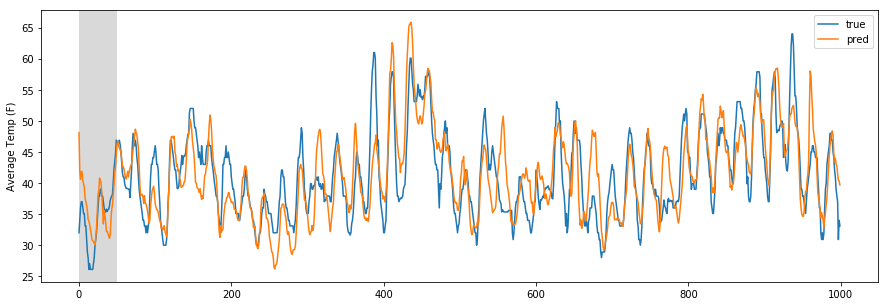

In [59]:
plot_comparison(start_idx=10000, length=1000, train=True)

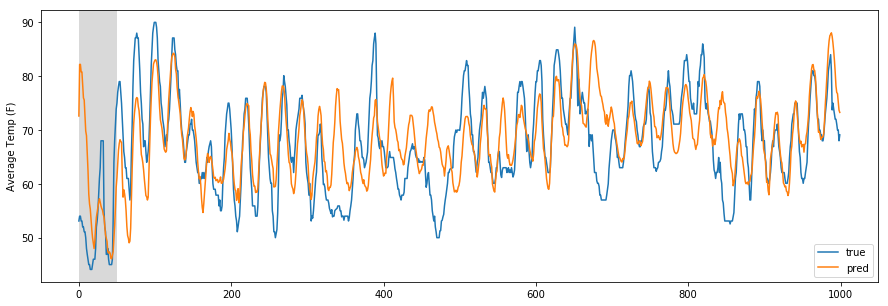

In [60]:
plot_comparison(start_idx=200, length=1000, train=False)
